In [1]:
import sys
sys.path.append('..')

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.models import common_neighbor_community as cnc

r_seed = 123

%load_ext autoreload
%autoreload 2

### Read dataset

Since the dataset is actually directed, we make it undirected to enable common neighbors methods.

In [2]:
G = nx.read_gml("../data/raw/polblogs.gml").to_undirected()
print("Number of nodes:", G.order())
print("Number of edges:", G.size())

Number of nodes: 1490
Number of edges: 16783


In [3]:
G.nodes["100monkeystyping.com"]

{'value': 0, 'source': 'Blogarama'}

In [4]:
actual_com = {}
for i in G.nodes:
    actual_com[i] = G.nodes[i]["value"]

actual_com["100monkeystyping.com"]


0

## Find the best threshold and test performance

Simply try a range of possible thresholds

In [5]:
def differentThes(lower_thres, higher_thres, interval, CNC):
    avg_accs = []
    ths = []
    max_thres = None
    max_acc = 0.0
    for thres in np.arange(lower_thres, higher_thres, interval):
        CNC.findAllCommunities(thres=thres, weighted=True)
        ths.append(thres)
        acc = CNC.getAvgAccuracy()
        avg_accs.append(acc)
        
        if acc > max_acc:
            max_acc = acc
            max_thres = thres
    
    return pd.DataFrame({"accuracy": avg_accs, "threshold": ths}), max_acc, max_thres

def plotThresAcc(df):
    sns.lineplot(data=df, x="threshold", y="accuracy")
    plt.title("Accuracy per Threshold")
    plt.show()
    plt.close()

Specifically, attemp $0.01$ to $0.50$ which means $1\%$ to $50\%$ degrees are common neighbors determine two nodes are within a same community.

Max Accuracy: 0.6535317271508283
Max Threshold: 0.01


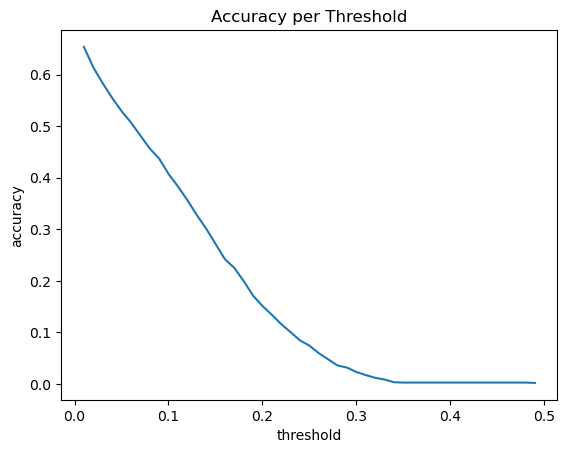

In [6]:
CNC = cnc.CommonNeighborCommunity(G, actual_com, overlapping=True) # reset the graph
df, max_acc, max_thres = differentThes(0.01, 0.5, 0.01, CNC)

CNC.findAllCommunities(thres=max_thres, weighted=True)

print("Max Accuracy:", max_acc)
print("Max Threshold:", max_thres)
plotThresAcc(df)

We can see the performance is better than the baseline and the default Louvain Algorithm. However, since we did not tuning for the Louvain, Louvain's resolution, Louvain Algorithm is still possibly better.